In [7]:
import pandas as pd

def load_data():
    data = {
        "normal": {
            "assault_double": pd.read_csv(
                "../data/32K_TUF/assault/assault_double_training_history.csv"
            ),
            "assault_rainbow": pd.read_csv(
                "../data/32K_TUF/assault/assault_rainbow_training_history.csv"
            ),
            "breakout_double": pd.read_csv(
                "../data/32K_TUF/breakout/breakout_double_training_history.csv"
            ),
            "breakout_rainbow": pd.read_csv(
                "../data/32K_TUF/breakout/breakout_rainbow_training_history.csv"
            ),
        },
        "10k": {
            "assault_double": pd.read_csv(
                "../data/10K_TUF/assault/assault_double_training_history.csv"
            ),
            "assault_rainbow": pd.read_csv(
                "../data/10K_TUF/assault/assault_rainbow_training_history.csv"
            ),
            "breakout_double": pd.read_csv(
                "../data/10K_TUF/breakout/breakout_double_training_history.csv"
            ),
            "breakout_rainbow": pd.read_csv(
                "../data/10K_TUF/breakout/breakout_rainbow_training_history.csv"
            ),
        },
        "random": {
            "assault": pd.read_csv(
                "../data/test_random_assault_double.csv"
            ),
            "breakout": pd.read_csv(
                "../data/test_random_breakout_double.csv"
            ),
        },
        "transfer_learning": {
            "a=>b": pd.read_csv(
                "../data/32K_TUF/a=>b rb/a=>b_5m_32k_training_history.csv"
            ),
            "b=>a": pd.read_csv(
                "../data/32K_TUF/b=>a rb/b=>a_5m_32k_training_history.csv"
            ),
        }
    }
    return data


In [8]:
def better_spines(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)

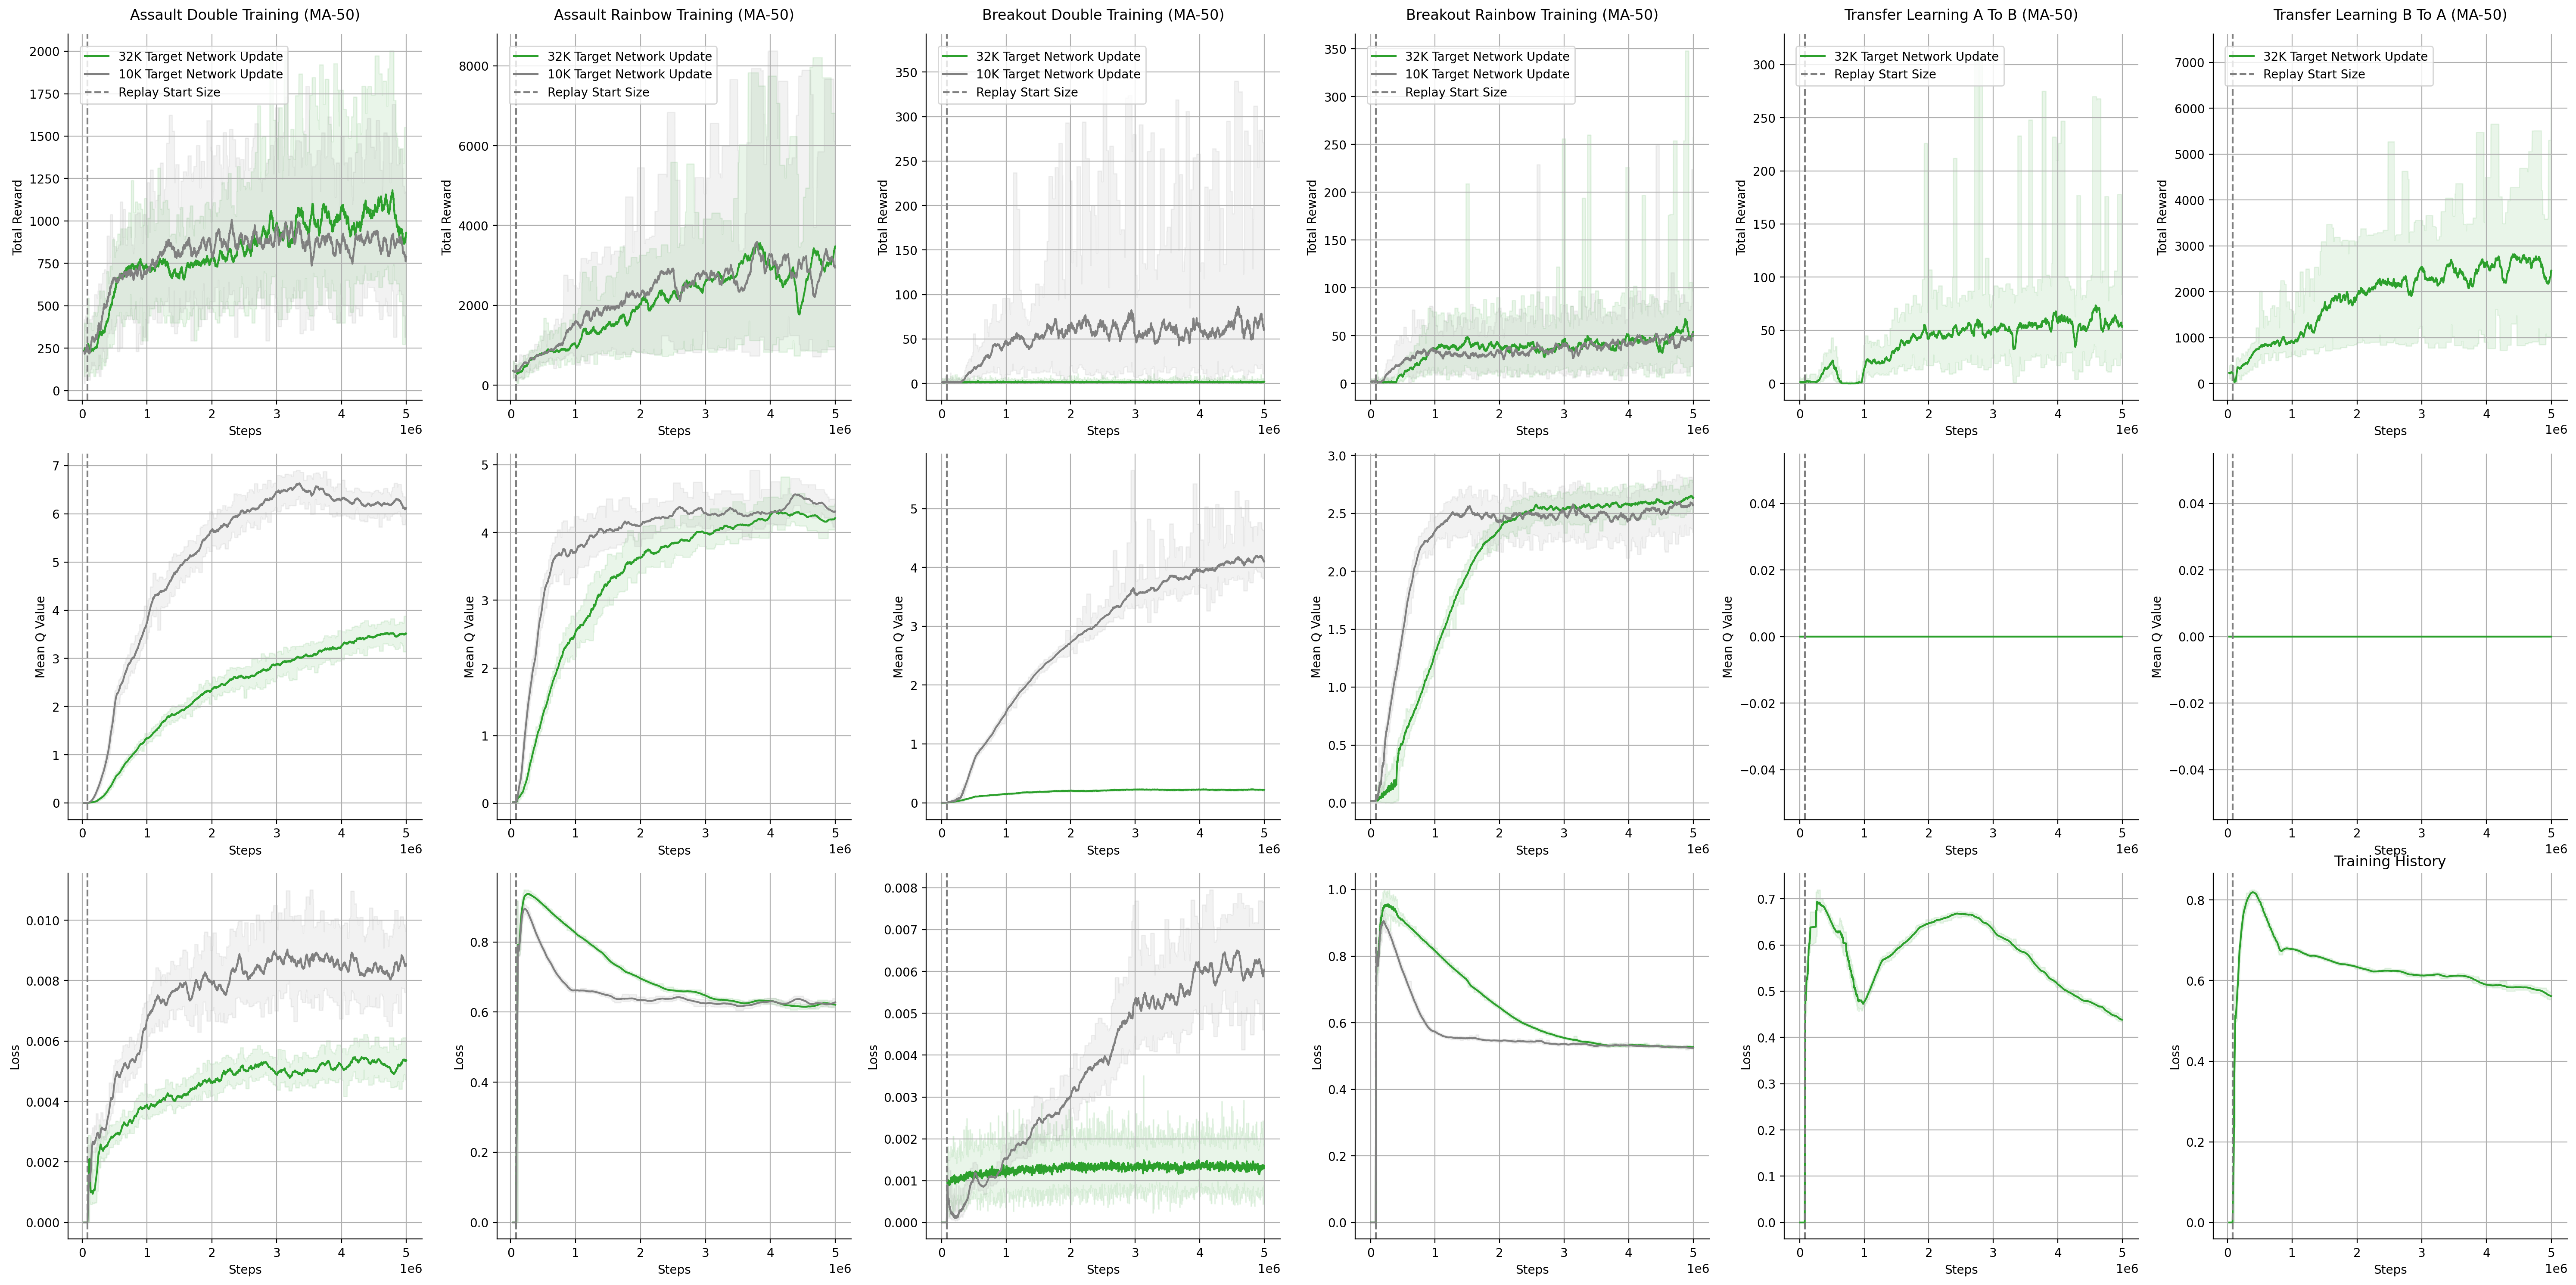

In [17]:
import matplotlib.pyplot as plt

REPLAY_START_SIZE = 80_000  # Size of replay memory before starting training

data = load_data()

window_size = 50

def calculate_moving_averages(df, window_size):
    df["episode_rewards_ma"] = df["episode_rewards"].rolling(window=window_size).mean()
    df["episode_rewards_min"] = df["episode_rewards"].rolling(window=window_size).min()
    df["episode_rewards_max"] = df["episode_rewards"].rolling(window=window_size).max()
    if "loss" in df:
        df["loss_ma"] = df["loss"].rolling(window=window_size).mean()
        df["loss_min"] = df["loss"].rolling(window=window_size).min()
        df["loss_max"] = df["loss"].rolling(window=window_size).max()
        df["mean_q_value_ma"] = df["mean_q_value"].rolling(window=window_size).mean()
        df["mean_q_value_min"] = df["mean_q_value"].rolling(window=window_size).min()
        df["mean_q_value_max"] = df["mean_q_value"].rolling(window=window_size).max()

# Apply the function to each DataFrame
for key in data["normal"]:
    calculate_moving_averages(data["normal"][key], window_size)
    calculate_moving_averages(data["10k"][key], window_size)

for key in data["transfer_learning"]:
    calculate_moving_averages(data["transfer_learning"][key], window_size)

def plot_dict(axes, column, title, plot_infos_32k, plot_infos_10k, REPLAY_START_SIZE):
    # Plot smoothed total rewards for 32k
    axes[0, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["episode_rewards_ma"])],
        plot_infos_32k["episode_rewards_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[0, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["episode_rewards_ma"])],
        plot_infos_32k["episode_rewards_min"],
        plot_infos_32k["episode_rewards_max"],
        color="C2",
        alpha=0.1,
    )

    if plot_infos_10k:
        # Plot smoothed total rewards for 10k
        axes[0, column].plot(
            plot_infos_10k["steps"][: len(plot_infos_10k["episode_rewards_ma"])],
            plot_infos_10k["episode_rewards_ma"],
            label="10K Target Network Update",
            color="gray",
        )
        axes[0, column].fill_between(
            plot_infos_10k["steps"][: len(plot_infos_10k["episode_rewards_ma"])],
            plot_infos_10k["episode_rewards_min"],
            plot_infos_10k["episode_rewards_max"],
            color="gray",
            alpha=0.1,
        )

    axes[0, column].set_ylabel("Total Reward")
    axes[0, column].set_xlabel("Steps")
    axes[0, column].grid(True)
    axes[0, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    axes[0, column].legend(loc="upper left", borderaxespad=1.0).set_zorder(2)
    better_spines(axes[0, column])

    # Plot mean Q value
    axes[1, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["mean_q_value_ma"])],
        plot_infos_32k["mean_q_value_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[1, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["mean_q_value_ma"])],
        plot_infos_32k["mean_q_value_min"],
        plot_infos_32k["mean_q_value_max"],
        color="C2",
        alpha=0.1,
    )

    if plot_infos_10k:
        axes[1, column].plot(
        plot_infos_10k["steps"][: len(plot_infos_10k["mean_q_value_ma"])],
        plot_infos_10k["mean_q_value_ma"],
        label="10K Target Network Update",
        color="gray",
        )
        axes[1, column].fill_between(
            plot_infos_10k["steps"][: len(plot_infos_10k["mean_q_value_ma"])],
            plot_infos_10k["mean_q_value_min"],
            plot_infos_10k["mean_q_value_max"],
            color="gray",
            alpha=0.1,
        )

    axes[1, column].set_ylabel("Mean Q Value")
    axes[1, column].set_xlabel("Steps")
    axes[1, column].grid(True)
    axes[1, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    better_spines(axes[1, column])

    # Plot loss
    axes[2, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["loss_ma"])],
        plot_infos_32k["loss_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[2, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["loss_ma"])],
        plot_infos_32k["loss_min"],
        plot_infos_32k["loss_max"],
        color="C2",
        alpha=0.1,
    )

    if plot_infos_10k:
        axes[2, column].plot(
            plot_infos_10k["steps"][: len(plot_infos_10k["loss_ma"])],
            plot_infos_10k["loss_ma"],
            label="10K Target Network Update",
            color="gray",
        )
        axes[2, column].fill_between(
            plot_infos_10k["steps"][: len(plot_infos_10k["loss_ma"])],
            plot_infos_10k["loss_min"],
            plot_infos_10k["loss_max"],
            color="gray",
            alpha=0.1,
        )

    axes[2, column].set_ylabel("Loss")
    axes[2, column].set_xlabel("Steps")
    axes[2, column].grid(True)
    axes[2, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    better_spines(axes[2, column])
    
    # set title
    axes[0, column].set_title(title, y=1.02)

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(30, 15), dpi=200)

# Convert the DataFrame back to a dictionary
for i, key in enumerate(data["normal"]):
    pi_32k = data["normal"][key].to_dict(orient="list")
    pi_10k = data["10k"][key].to_dict(orient="list")
    plot_dict(axes, i, f"{key.replace('_', ' ').title()} Training (MA-50)", pi_32k, pi_10k, REPLAY_START_SIZE)

# Add transfer learning plots
for i, key in enumerate(data["transfer_learning"]):
    pi_32k = data["transfer_learning"][key].to_dict(orient="list")
    plot_dict(axes, i + len(data["normal"]), f"Transfer Learning {key.replace('=>', ' to ').title()} (MA-50)", pi_32k, None, REPLAY_START_SIZE)

fig.tight_layout()
plt.title("Training History")
plt.show()

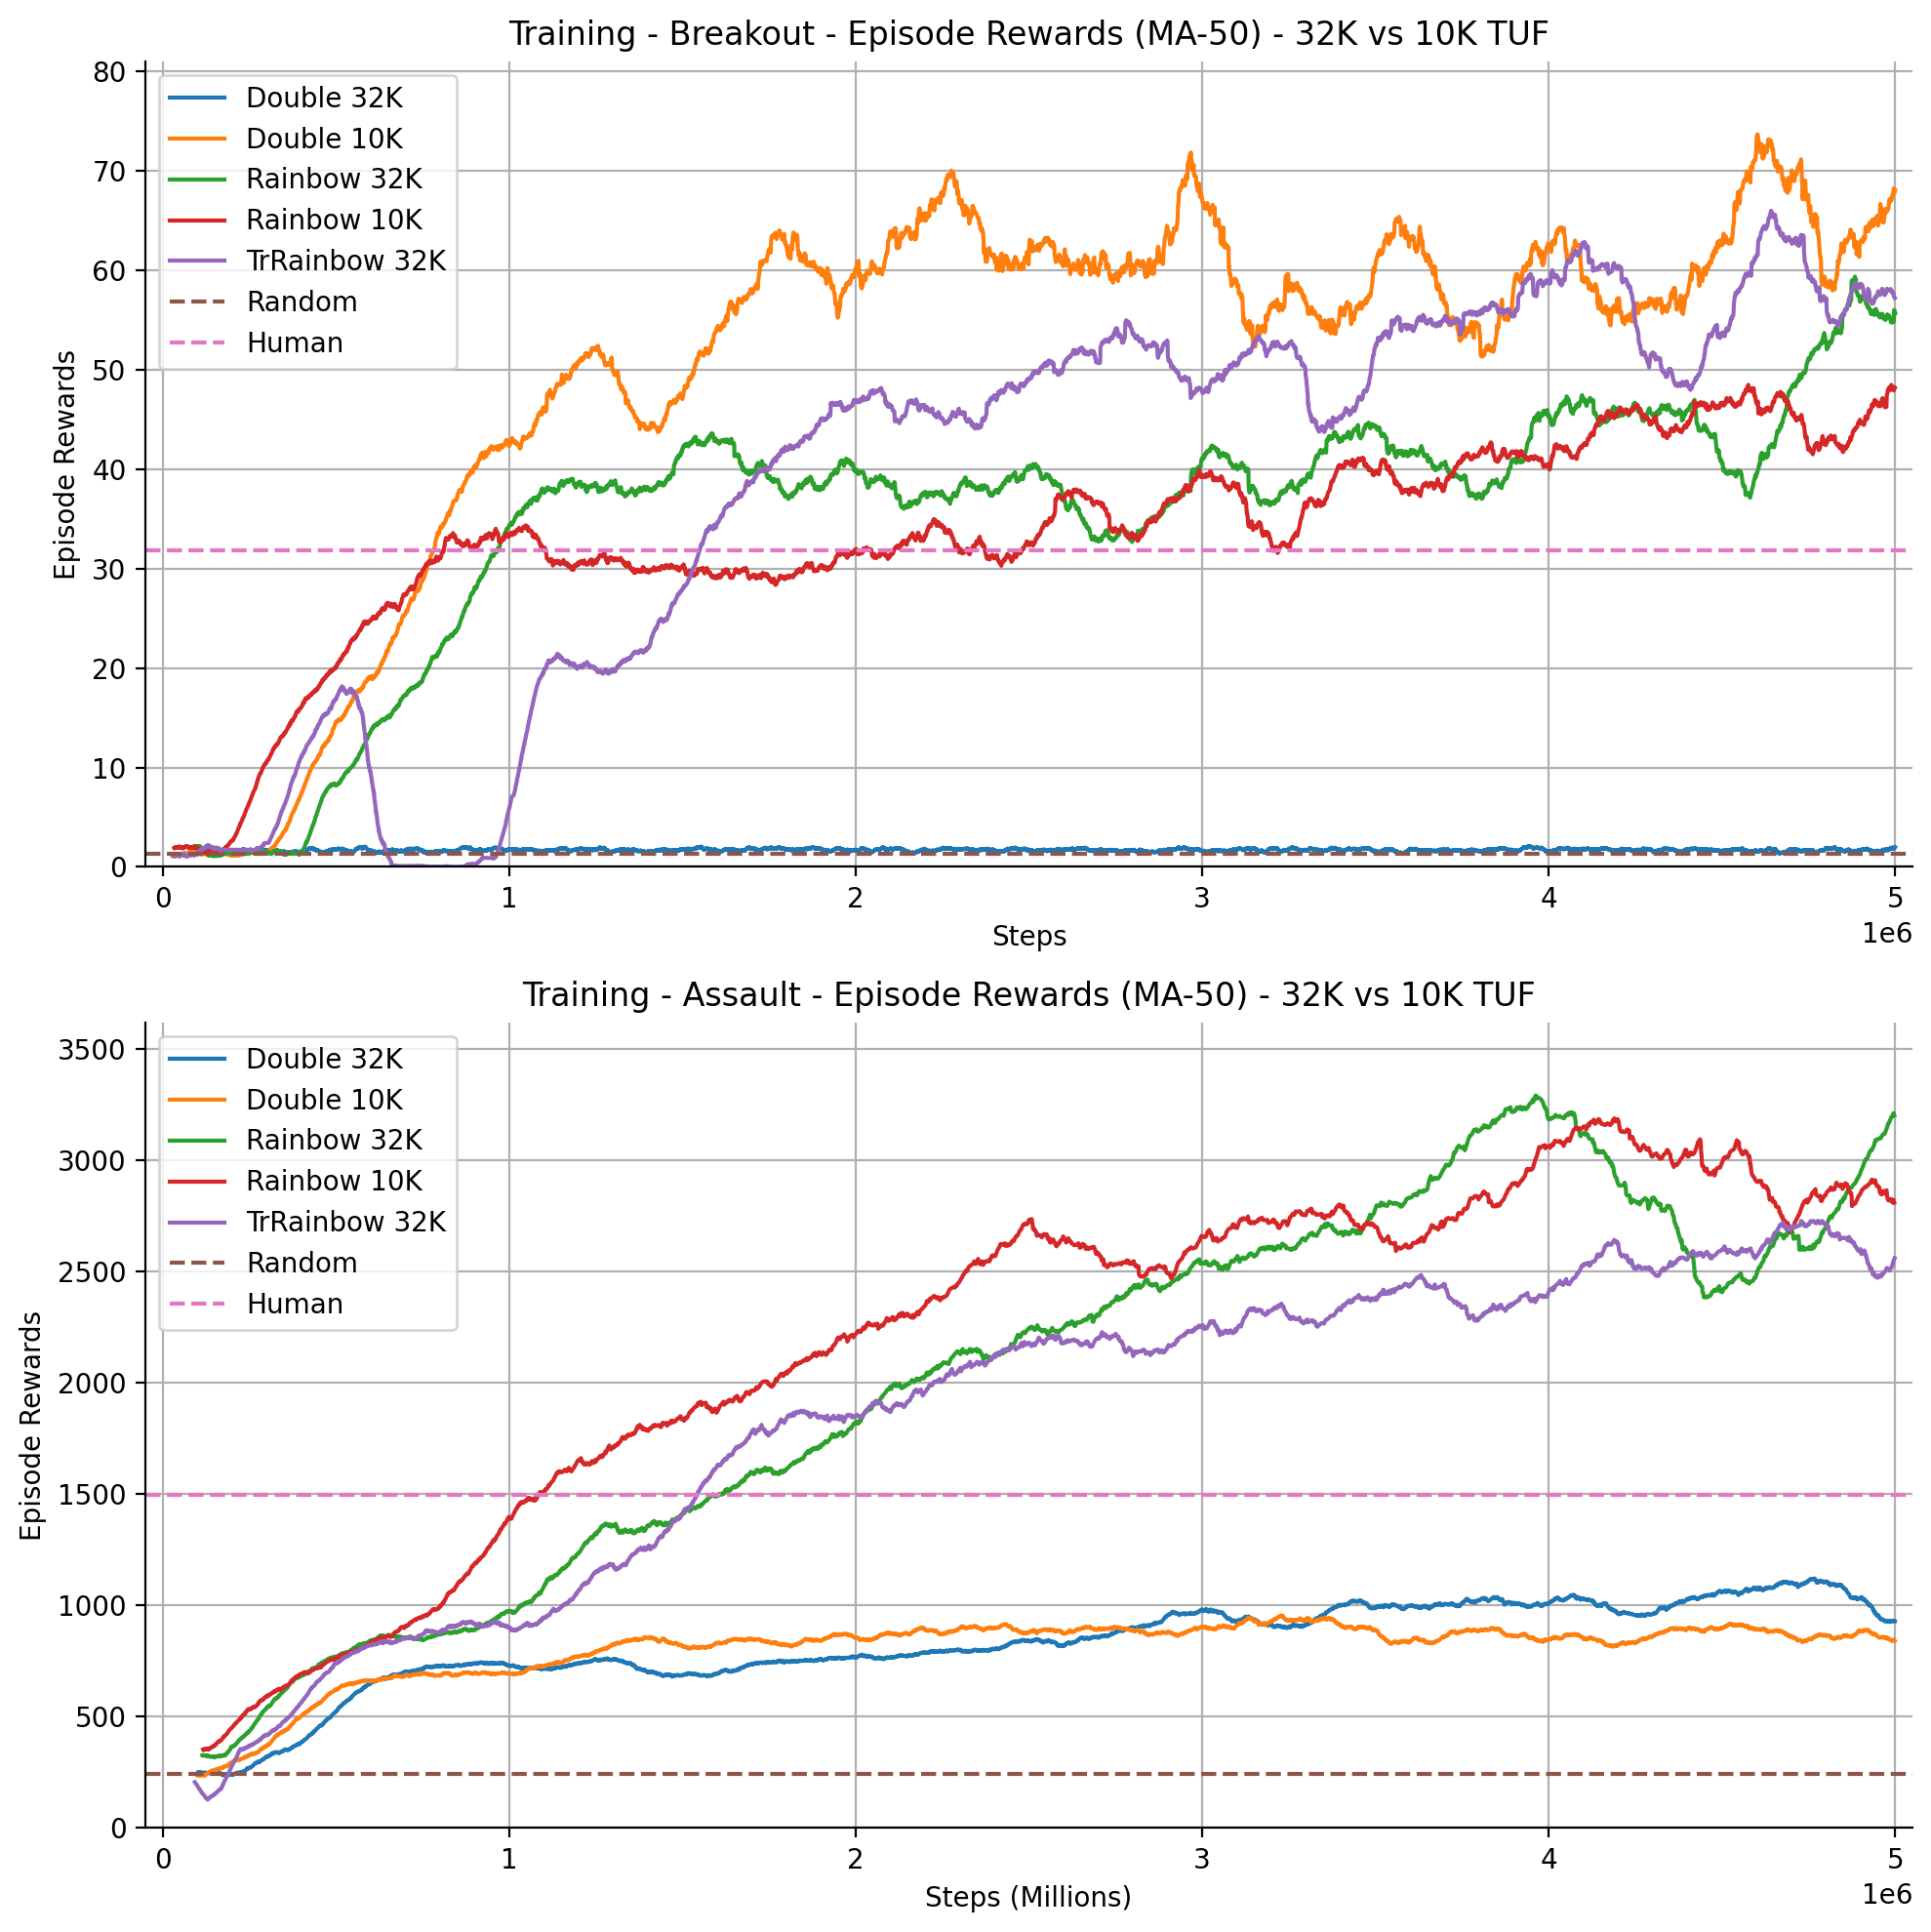

In [16]:
import matplotlib.pyplot as plt

human_breakout = 31.8
human_assault = 1496.0

def calculate_episode_rewards_moving_averages(df, window_size):
    df["episode_rewards_ma"] = df["episode_rewards"].rolling(window=window_size).mean()
    df["episode_rewards_min"] = df["episode_rewards"].rolling(window=window_size).min()
    df["episode_rewards_max"] = df["episode_rewards"].rolling(window=window_size).max()

def apply_moving_averages(data, window_size):
    for key in data:
        for df in data[key].values():
            if "episode_rewards" in df:
                calculate_episode_rewards_moving_averages(df, window_size)

def calculate_random_baselines(df_random):
    random_mean = df_random["mean_reward"].mean()
    random_min = df_random["min_reward"].mean()
    random_max = df_random["max_reward"].mean()
    return random_mean, random_min, random_max

def plot_data(
    axes,
    datasets,
    random_mean,
    random_min,
    random_max,
    human,
    title,
    xlabel,
    ylabel,
    colors,
    labels
):
    for df, color, label in zip(datasets, colors, labels):
        axes.plot(
            df["steps"],
            df["episode_rewards_ma"],
            label=label,
            color=color,
        )

    axes.axhline(y=random_mean, color="C5", linestyle="--", label="Random")
    axes.axhline(y=human, color="C6", linestyle="--", label="Human")

    axes.set_xlim([-50_000, 5_050_000])
    axes.set_ylim(
        [
            0,
            max(
                max(df["episode_rewards_ma"].max() for df in datasets),
                random_max,
            )
            * 1.1,
        ]
    )

    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend()
    axes.grid(True)
    better_spines(axes)

window_size = int(50 / 15 * 50)
apply_moving_averages(data, window_size)

breakout_random_mean, breakout_random_min, breakout_random_max = (
    calculate_random_baselines(data["random"]["breakout"])
)
assault_random_mean, assault_random_min, assault_random_max = (
    calculate_random_baselines(data["random"]["assault"])
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=200)

# Plot Breakout data
plot_data(
    axes[0],
    [
        data["normal"]["breakout_double"],
        data["10k"]["breakout_double"],
        data["normal"]["breakout_rainbow"],
        data["10k"]["breakout_rainbow"],
        data["transfer_learning"]["a=>b"]
    ],
    breakout_random_mean,
    breakout_random_min,
    breakout_random_max,
    human_breakout,
    "Training - Breakout - Episode Rewards (MA-50) - 32K vs 10K TUF",
    "Steps",
    "Episode Rewards",
    ["C0", "C1", "C2", "C3", "C4"],  # Added color for transfer learning
    ["Double 32K", "Double 10K", "Rainbow 32K", "Rainbow 10K", "TrRainbow 32K"]  # Added label for transfer learning
)

# Plot Assault data
plot_data(
    axes[1],
    [
        data["normal"]["assault_double"],
        data["10k"]["assault_double"],
        data["normal"]["assault_rainbow"],
        data["10k"]["assault_rainbow"],
        data["transfer_learning"]["b=>a"]
    ],
    assault_random_mean,
    assault_random_min,
    assault_random_max,
    human_assault,
    "Training - Assault - Episode Rewards (MA-50) - 32K vs 10K TUF",
    "Steps (Millions)",
    "Episode Rewards",
    ["C0", "C1", "C2", "C3", "C4"],
    ["Double 32K", "Double 10K", "Rainbow 32K", "Rainbow 10K", "TrRainbow 32K"]  # Added label for transfer learning
)

plt.tight_layout()
plt.show()
